In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import re

import json 
import torch
import json_repair
import pandas as pd
from glob import glob 
from openai import OpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from pqdm.processes import pqdm
from datasets import Dataset, load_dataset
from trl import SFTTrainer
from peft import AutoPeftModelForCausalLM, LoraConfig
from transformers import (AutoTokenizer, 
                          AutoModelForCausalLM, 
                          TrainingArguments, 
                          pipeline)


# 제작한 데이터세 불러오기 
file_list = glob("./data/*.csv")
print(file_list)

df = pd.concat([pd.read_csv(file) for file in file_list])
df.shape

/home/admin/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['./data/보험 상담_final_20250315_013253.csv', './data/이벤트_안내글_final_20250322_164822.csv', './data/모임_동호회_홍보글_final_20250322_164822.csv', './data/은행 상담_final_20250315_013253.csv', './data/강의_세미나_홍보글_final_20250322_164822.csv', './data/제품_리뷰글_final_20250322_164822.csv', './data/중고나라_게시물_final_20250322_164822.csv', './data/쇼핑 고객 서비스_final_20250315_013253.csv']


(773, 9)

In [2]:
def extract_placeholder_mapping(original_text, transformed_text, allowed_types):
    allowed_pattern = re.compile(r'\[(' + '|'.join(allowed_types) + r')\d*\]')
    generic_pattern = re.compile(r'(\[[^]]+\])')

    mapping = {}

    orig_lines = original_text.splitlines()
    trans_lines = transformed_text.splitlines()
    n_lines = min(len(orig_lines), len(trans_lines))

    for idx in range(n_lines):
        orig_line = orig_lines[idx]
        trans_line = trans_lines[idx]

        parts = re.split(generic_pattern, trans_line)
        orig_pos = 0

        for i, part in enumerate(parts):
            if allowed_pattern.match(part):
                # placeholder 발견
                # 다음 literal을 찾음
                next_literal = parts[i + 1] if i + 1 < len(parts) else ''
                
                # 다음 literal이 존재하면, 그 literal까지의 텍스트를 추출
                if next_literal:
                    next_idx = orig_line.find(next_literal, orig_pos)
                    if next_idx != -1:
                        replaced_text = orig_line[orig_pos:next_idx]
                        orig_pos = next_idx
                    else:
                        # 다음 literal을 못 찾으면 끝까지
                        replaced_text = orig_line[orig_pos:]
                        orig_pos = len(orig_line)
                else:
                    # 다음 literal이 없으면 남은 텍스트 전체
                    replaced_text = orig_line[orig_pos:]
                    orig_pos = len(orig_line)

                replaced_text = replaced_text.strip()
                if replaced_text:
                    mapping[replaced_text] = part

            else:
                # literal인 경우, 원본에서 위치 업데이트
                found_idx = orig_line.find(part, orig_pos)
                if found_idx != -1:
                    orig_pos = found_idx + len(part)

    return mapping

df.head(2)

,origin_data,category,generate_score,generate_reason,anonymized_data,anonymized_prompt,validate_score,validate_reason,mapping
0,"상담사: ""안녕하세요, 김은주 고객님! 상담사 이현준입니다. 오늘 보험 상담 도와드...",보험 상담,5,"데이터는 모든 평가 기준을 완벽히 만족합니다. \n\n1. 개인정보 포함: 이름, ...","상담사: ""안녕하세요, [PERSON1] 고객님! 상담사 [PERSON2]입니다. ...",입력 데이터에 포함된 모든 개인정보를 위 placeholder를 사용하여 비식별화 ...,5,"모든 개인정보가 적절하게 비식별화되었습니다. 이름, 생년월일, 연락처, 주소, 이메...","{'김은주': '[PERSON1]', '이현준': '[PERSON2]', '1985..."
1,"상담사: ""안녕하세요, 김하나 고객님. 보험 상담을 도와드릴 김상진입니다. 생년월일...",보험 상담,5,데이터는 모든 평가 기준을 완벽히 만족하고 있습니다. \n1. 개인정보 포함: 이름...,"상담사: ""안녕하세요, [PERSON1] 고객님. 보험 상담을 도와드릴 [PERSO...",입력 데이터에 포함된 모든 개인정보를 위 placeholder를 사용하여 비식별화 ...,5,"모든 개인정보가 적절하게 비식별화되었으며, 동일한 개인정보는 일관된 placehol...","{'김하나': '[PERSON1]', '김상진': '[PERSON2]', '1985..."


In [3]:
print(df["origin_data"].iloc[20])
print("--------------")
print(df["anonymized_data"].iloc[20])

상담사: "안녕하세요, 김미영 고객님. 보험 상담을 도와드릴 홍성철입니다. 생일이 1985년 4월 12일로 등록되어 있습니다. 맞으신가요?"

고객: "네, 맞습니다. 요즘 보험에 대해 좀 더 알아보고 싶어서요."

상담사: "현재 사용 중인 연락처는 010-1234-5678이 맞으신가요? 이메일은 kimmyoung85@gmail.com으로 알고 있습니다."

고객: "네, 두 정보 모두 정확합니다."

상담사: "감사합니다. 현재 저희 보험 상품 중 보장성 보험에 관심이 있으신 걸로 알고 있습니다. 혹시 주소는 예전에 등록된 서울시 용산구 이태원로 123으로 변경된 부분이 없으신가요?"

고객: "아, 주소는 이제 서울시 성동구 왕십리로 456으로 변경되었습니다."

상담사: "확인 감사합니다. 그러면 현재 보장 내용이나 보험료 등에 대해 더 자세히 설명해 드려도 될까요?"

고객: "네, 좋습니다. 제가 현재 가입된 보험이랑 비교해서 어떤 차이가 있는지도 궁금합니다."

상담사: "알겠습니다. 고객님의 현재 보험 내용과 저희 상품을 비교해서 최적의 선택을 도와드릴 수 있도록 하겠습니다. 더 궁금하신 점이 있으면 언제든지 말씀해 주세요."

고객: "네, 감사합니다. 혹시 카카오톡 ID로도 안내를 받을 수 있을까요? 아이디는 kimmykakao입니다."

상담사: "물론입니다. 카카오톡으로도 정보를 보내드리겠습니다. 상담 진행 중 궁금한 점이 있으면 언제든지 메시지 주세요."

고객: "알겠습니다. 잘 부탁드립니다."
--------------
상담사: "안녕하세요, [PERSON1] 고객님. 보험 상담을 도와드릴 [PERSON2]입니다. 생일이 [DATEOFBIRTH1]로 등록되어 있습니다. 맞으신가요?"

고객: "네, 맞습니다. 요즘 보험에 대해 좀 더 알아보고 싶어서요."

상담사: "현재 사용 중인 연락처는 [CONTACT1]이 맞으신가요? 이메일은 [EMAIL1]으로 알고 있습니다."

고객: "네, 두 정보 모두 정확합니다."

상담사: "감사합

In [4]:
print(df["origin_data"].iloc[-2])
print("--------------")
print(df["anonymized_data"].iloc[-2])

상담사: "안녕하세요, 김민수 고객님. 고객 서비스 센터의 이지현입니다. 어떻게 도와드릴까요?"

고객: "안녕하세요. 제가 지난주에 주문한 가전제품에 문제가 있어서요. 주문 번호는 20231012-4578이고, 제품은 삼성 스마트 TV입니다."

상담사: "네, 확인해 보겠습니다. 문제는 어떤 점에서 발생했나요?"

고객: "화면에 갑자기 선이 나타나더니 사라지지 않아요. 10월 5일에 도착했고, 주소는 서울시 강남구 테헤란로 123, 5층입니다."

상담사: "불편을 드려 죄송합니다, 김민수 고객님. 확인해 보니 제품 보증 기간 내이십니다. 교체 또는 환불 원하시는지 말씀해 주세요."

고객: "교체를 원합니다. 그리고 혹시 교체 과정에서 필요한 게 따로 있을까요?"

상담사: "교체를 진행해 드리겠습니다. 연락 가능한 전화번호는 010-1234-5678 맞으신가요?"

고객: "네, 맞습니다. 이메일로도 연락 부탁드릴게요. 제 이메일은 minsoo.kim@example.com입니다."

상담사: "확인되었습니다. 새로운 제품은 약 3~5일 내에 배송될 예정입니다. 진행 상황은 010-1234-5678로 안내해 드리겠습니다. 다른 문의 사항 있으실까요?"

고객: "네, 이지현 상담사님 감사합니다. 없습니다. 좋은 하루 보내세요."

상담사: "감사합니다, 김민수 고객님. 좋은 하루 되세요!"
--------------
상담사: "안녕하세요, [PERSON1] 고객님. 고객 서비스 센터의 [PERSON2]입니다. 어떻게 도와드릴까요?"

고객: "안녕하세요. 제가 지난주에 주문한 가전제품에 문제가 있어서요. 주문 번호는 20231012-4578이고, 제품은 삼성 스마트 TV입니다."

상담사: "네, 확인해 보겠습니다. 문제는 어떤 점에서 발생했나요?"

고객: "화면에 갑자기 선이 나타나더니 사라지지 않아요. 10월 5일에 도착했고, 주소는 [ADDRESS1]입니다."

상담사: "불편을 드려 죄송합니다, [PERSON1] 고객님. 확인해 보니 제품 보증

In [5]:
df["mapping"] = df["mapping"].map(lambda x: str(x))

In [6]:
import datasets 

dataset = datasets.Dataset.from_pandas(df)

def get_chat_format(element):
    system_prompt = "너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해."

    return {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": element["origin_data"]},
            {"role": "assistant", "content": element["anonymized_data"]},
        ], 
        "label": element["mapping"]
    }

dataset = dataset.map(get_chat_format, remove_columns=dataset.features, batched=False)
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.1, seed=42)

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Map: 100%|██████████| 773/773 [00:00<00:00, 15333.52 examples/s]


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['messages', 'label'],
        num_rows: 695
    })
    test: Dataset({
        features: ['messages', 'label'],
        num_rows: 78
    })
})

In [8]:
dataset["train"][0]

{'messages': [{'content': '너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해.',
   'role': 'system'},
  {'content': '상담사: "안녕하세요, 쇼핑 고객 센터입니다. 무엇을 도와드릴까요?"\n\n고객: "안녕하세요. 저는 김민수입니다. 어제 주문한 상품 배송 상태를 확인하고 싶어서요. 제 연락처는 010-1234-5678이고, 주문번호는 ORD1234567입니다."\n\n상담사: "확인해보겠습니다, 김민수 고객님. 지금 확인 결과, 주문하신 상품은 오늘 발송되었으며 내일 도착 예정입니다. 혹시 배송 주소를 김해시 동상동 123-45번지로 등록하셨나요?"\n\n고객: "네, 맞습니다. 그런데 내일 제가 하루 종일 외출할 예정인데, 배송 일자를 변경할 수 있을까요?"\n\n상담사: "물론입니다. 편하신 일자를 말씀해 주시면 변경해 드리겠습니다."\n\n고객: "그럼 이번 주 토요일로 변경 부탁드려요."\n\n상담사: "네, 김민수 고객님의 요청대로 배송 일정을 이번 주 토요일로 조정하겠습니다. 혹시 다른 문의 사항 있으신가요?"\n\n고객: "아, 그리고 제 이메일 minsoo.kim@example.com으로 배송 확인 메시지도 보내주시겠어요?"\n\n상담사: "물론입니다. 요청하신 이메일로 배송 확인 메시지를 곧 보내드리겠습니다. 다른 궁금한 점 있으시면 언제든지 말씀해 주세요."\n\n고객: "네, 감사합니다. 그럼 연락 기다릴게요."\n\n상담사: "네, 감사합니다. 좋은 하루 되세요, 김민수 고객님."',
   'role': 'user'},
  {'content': '상담사: "안녕하세요, 쇼핑 고객 센터입니다. 무엇을 도와드릴까요?"\n\n고객: "안녕하세요. 저는 [PERSON1]입니다. 어제 주문한 상품 배송 상태를 확인하고 싶어서요. 제 연락처는 [CONTACT1]이고, 주문번호는 [ORDER1]입니다."\n\n상담사: "확인해보겠습

In [9]:
lora_alpha = 8
lora_r = 16
learning_rate = 2e-4

peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=0.05,
        r=lora_r,
        bias="none",
        target_modules=[
            "q_proj",
            "up_proj",
            "o_proj",
            "k_proj",
            "down_proj",
            "gate_proj",
            "v_proj"],
        task_type="CAUSAL_LM",
)

save_dir = f"./model/model_{learning_rate}_alpha-{lora_alpha}_r-{lora_r}"

args = TrainingArguments(
    output_dir=f"{save_dir}",       # 훈련된 모델과 체크포인트(checkpoint), 로그 등 훈련 결과물들이 저장될 위치를 지정합니다.
    num_train_epochs=2,             # 전체 데이터셋을 몇 번 반복하여 훈련할지 설정합니다.
    per_device_train_batch_size=2,  # 각 장치(device)에서 사용할 배치 크기를 설정합니다.
    gradient_accumulation_steps=4,  # 배치 크기가 크거나 메모리 부족 등의 이유로 모델을 훈련할 때 메모리 부족이 발생하는 경우, 배치 크기를 나누어 모델을 훈련할 수 있도록 합니다.
                                    # 예시로는 4개 배치의 gradient를 누적 후 한번에 가중치를 업데이트합니다.
                                    # 실질적 배치 사이즈 = per_device_train_batch_size × gradient_accumulation_steps (예: 2×4=8)
    gradient_checkpointing=True,    # 메모리를 절약하기 위해 중간 레이어의 출력을 저장하지 않고, 필요할 때 다시 계산합니다.
    optim="adamw_torch_fused",      # 여기서는 adamw_torch_fused를 사용하여 속도를 최적화한 PyTorch 기반 AdamW 최적화기를 사용합니다.
    logging_steps=2,                # 로그를 출력할 때 몇 번째 반복마다 출력할지 설정합니다.
    save_strategy="epoch",          # 체크포인트를 저장할 때 몇 번째 반복마다 저장할지 설정합니다.
                                    # 다른 옵션: "steps" (지정한 스텝마다 저장), "no" (저장하지 않음)
    learning_rate=learning_rate,    # 모델 파라미터가 업데이트되는 폭을 결정하는 중요한 값입니다.
    bf16=True,                      # bf16=True로 설정하면, 메모리 사용량을 줄이고 학습 속도를 빠르게 하는 **혼합 정밀도 학습(mixed-precision)**을 활성화합니다.
                                    # 특히 Nvidia의 최신 GPU나 TPU 환경에서 성능과 메모리 사용 효율이 높아집니다.
    tf32=True,                      # Nvidia Ampere 이상 GPU에서 빠른 연산을 지원하는 TensorFloat-32를 사용합니다.
    max_grad_norm=0.3,              # Gradient clipping의 최대 한계를 지정하여 Gradient가 너무 커져 폭발(explode)하는 현상을 막아줍니다. 이 값으로 gradient의 norm을 제한합니다.
    # | 상황           | Gradient norm | Clipping 여부                  |
    # |---------------|---------------|-------------------------------|
    # | 정상 gradient  | 0.2           | 변화 없음 (그대로 유지)            |
    # | 큰 gradient    | 1.2          | 0.3이 되도록 gradient 크기를 조정  |

    warmup_ratio=0.03,              # 초기에 학습률을 천천히 증가시키는 워밍업(warmup) 단계 비율을 나타냅니다. 전체 훈련의 3% 동안 학습률을 점차적으로 높입니다.
    lr_scheduler_type="constant", 
    push_to_hub=False,             
    report_to="wandb",            
)

In [10]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

# 이 설정은 토큰 시퀀스를 배치(batch) 단위로 처리할 때 길이가 서로 다를 수 있기 때문에, 짧은 문장에 패딩(padding)을 추가하여 같은 길이로 맞출 때 패딩 토큰을 오른쪽에 붙이라는 의미입니다.
# 예시 
# 원본 시퀀스: [1, 2, 3] 과 [4, 5]가 있다면
# 오른쪽 패딩을 설정할 때: [1, 2, 3], [4, 5, PAD] (PAD가 오른쪽에 붙음)
# 만약 왼쪽 패딩이라면: [1, 2, 3], [PAD, 4, 5] (PAD가 왼쪽에 붙음)
tokenizer.padding_side = 'right'  

# 이렇게 하는 이유는 모델에 따라 별도의 패딩 토큰이 정의되지 않은 경우, 종료 토큰(eos_token)을 패딩 토큰으로 사용하여 입력 길이를 맞춰주는 방식을 사용하는 경우가 많기 때문입니다.
# 일반적으로 GPT 계열과 같이 별도의 패딩 토큰이 설정되지 않은 모델에서는 eos_token을 패딩 토큰으로 사용하는 방법이 흔히 쓰입니다.
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


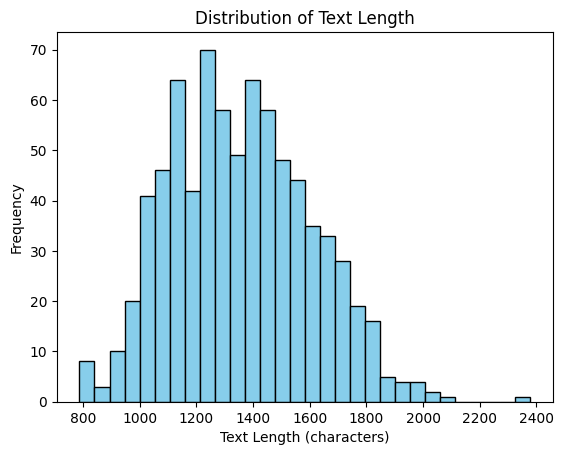

In [11]:
df["length"] = df["origin_data"].apply(len) + df["anonymized_data"].apply(len)

import matplotlib.pyplot as plt

plt.hist(df["length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

In [12]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    max_seq_length=2400,
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=True,
)

trainer.train()

trainer.save_model(f"{save_dir}")

/home/admin/.venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/admin/.venv/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:195: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/admin/.venv/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
Generating train split: 241 examples [00:00, 254.89 examples/s]
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was no

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/admin/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
2,1.113300
4,1.026000
6,0.974200
8,0.950800
10,0.877500
12,0.833700
14,0.808400
16,0.763100
18,0.730100
20,0.699600


/home/admin/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


In [13]:
del model
del tokenizer
torch.cuda.empty_cache()

In [14]:
# 학습한 모델을 경로를 지정합니다.
peft_model_id = f"{save_dir}"

# PEFT 어댑터를 통해 사전 학습된 모델을 로드합니다.
fine_tuned_model = AutoPeftModelForCausalLM.from_pretrained(
  peft_model_id,
  device_map="auto",
  torch_dtype=torch.float16
).to("cuda")

# 토크나이저 로드합니다.
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
tokenizer.padding_side = 'right'  
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


In [15]:
dataset["test"]

Dataset({
    features: ['messages', 'label'],
    num_rows: 78
})

In [16]:
pipe = pipeline("text-generation", model=fine_tuned_model, tokenizer=tokenizer, device_map="auto")

prompt = pipe.tokenizer.apply_chat_template(dataset["test"][-2]["messages"][:2], tokenize=False, add_generation_prompt=True)
print(prompt)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCaus

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

너는 개인정보를 비식별화하는 Assistant야. 너는 주어진 데이터를 바탕으로 개인정보를 비식별화하는 작업을 해야해.<|eot_id|><|start_header_id|>user<|end_header_id|>

안녕하세요! 여러분을 독서의 즐거움 속으로 초대합니다 📚✨

모임명: 따뜻한 책 한 권
활동 내용: 매달 다양한 주제의 책을 함께 읽고, 자유로운 토론을 통해 서로의 생각을 나누는 독서 모임입니다. 문학, 인문, 과학, 자기계발 등 다양한 분야의 책을 다룰 예정이며, 특별한 배경 지식이 없어도 모두 환영합니다!

모임 일시: 매월 첫째 주 수요일 저녁 7시
장소: 서울시 마포구 와우산로 29, 3층 카페 책마루

가입 방법: 이메일로 가입 신청서를 보내주시면 됩니다. 간단한 자기소개와 읽고 싶은 책 주제를 적어주세요. 이메일: warmbookclub@example.com

연락처: 모임에 대한 궁금한 점이나 문의사항이 있으시면 대표 김지수에게 연락 주세요. 전화번호: 010-5555-1234

추가 정보: 카카오톡 오픈채팅방을 운영 중입니다! 카카오톡 ID: warmbooks
함께 책과 친구가 되는 시간을 가질 수 있길 기대합니다. 책을 사랑하는 분들의 많은 참여 바랍니다! 📖❤️<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [17]:
outputs = pipe(
    prompt, 
    max_new_tokens=512,                         # 모델이 입력 테스트를 기반으로 새롭게 생성할 최대 토큰 개수를 지정합니다. 토큰의 개수가 이 숫자에 도달하거나 종료 토큰(eos_token)을 만나면 텍스트 생성을 종료합니다.
    do_sample=True,                             # 샘플링 기반 생성을 사용할지 여부를 결정합니다. 이 경우 모델은 확률 분포를 기반으로 토큰을 선택하여 생성합니다.
                                                # False면 모델은 항상 확률이 가장 높은 토큰을 선택해 생성합니다.
    temperature=0.1,                            # 생성 텍스트의 다양성을 조절하는 파라미터입니다. 0에 가까울수록 모델은 더 정확한 텍스트를 생성하고, 1에 가까울수록 더 다양한 텍스트를 생성합니다.
    top_k=40,                                   # 텍스트 생성 시 고려할 후보 토큰의 개수를 제한합니다.
                                                # 모델은 확률이 가장 높은 상위 40개 토큰 내에서만 선택하여 출력을 생성합니다.
	                                            # 값이 작을수록 제한된 범위에서 토큰을 선택하여 보수적이 되며, 값이 크면 더 넓은 범위를 선택합니다.
    top_p=0.9,                                  # 누적 확률값의 합이 일정 비율(top_p)을 초과할 때까지의 상위 토큰들을 후보로 제한하는 방식입니다.
    eos_token_id=pipe.tokenizer.eos_token_id,   # 모델이 이 토큰을 생성하면, 즉시 텍스트 생성을 종료합니다.
    pad_token_id=pipe.tokenizer.pad_token_id    # 생성된 문장의 길이가 서로 다를 때 길이를 맞추기 위해 패딩(padding)에 사용하는 토큰입니다.
)


/home/admin/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/admin/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/admin/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:623: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the mo

In [18]:
output_text = outputs[0]["generated_text"][len(prompt):]
print(output_text)

안녕하세요! 여러분을 독서의 즐거움 속으로 초대합니다 📚✨

모임명: 따뜻한 책 한 권
활동 내용: 매달 다양한 주제의 책을 함께 읽고, 자유로운 토론을 통해 서로의 생각을 나누는 독서 모임입니다. 문학, 인문, 과학, 자기계발 등 다양한 분야의 책을 다룰 예정이며, 특별한 배경 지식이 없어도 모두 환영합니다!

모임 일시: 매월 첫째 주 수요일 저녁 7시
장소: [ADDRESS1], 3층 카페 책마루

가입 방법: 이메일로 가입 신청서를 보내주시면 됩니다. 간단한 자기소개와 읽고 싶은 책 주제를 적어주세요. 이메일: [EMAIL1]

연락처: 모임에 대한 궁금한 점이나 문의사항이 있으시면 대표 [PERSON1]에게 연락 주세요. 전화번호: [CONTACT1]

추가 정보: 카카오톡 오픈채팅방을 운영 중입니다! 카카오톡 ID: [KAKAO_ID1]
함께 책과 친구가 되는 시간을 가질 수 있길 기대합니다. 책을 사랑하는 분들의 많은 참여 바랍니다! 📖❤️


In [ ]:
# 인퍼런스 속도가 늦기 때문에 vLLM sgLang 같은 라이브러리를 사용하여 실제로는 많이 사용합니다. 

In [19]:
input_text = dataset["test"][-2]["messages"][1]["content"]
print(input_text)

안녕하세요! 여러분을 독서의 즐거움 속으로 초대합니다 📚✨

모임명: 따뜻한 책 한 권
활동 내용: 매달 다양한 주제의 책을 함께 읽고, 자유로운 토론을 통해 서로의 생각을 나누는 독서 모임입니다. 문학, 인문, 과학, 자기계발 등 다양한 분야의 책을 다룰 예정이며, 특별한 배경 지식이 없어도 모두 환영합니다!

모임 일시: 매월 첫째 주 수요일 저녁 7시
장소: 서울시 마포구 와우산로 29, 3층 카페 책마루

가입 방법: 이메일로 가입 신청서를 보내주시면 됩니다. 간단한 자기소개와 읽고 싶은 책 주제를 적어주세요. 이메일: warmbookclub@example.com

연락처: 모임에 대한 궁금한 점이나 문의사항이 있으시면 대표 김지수에게 연락 주세요. 전화번호: 010-5555-1234

추가 정보: 카카오톡 오픈채팅방을 운영 중입니다! 카카오톡 ID: warmbooks
함께 책과 친구가 되는 시간을 가질 수 있길 기대합니다. 책을 사랑하는 분들의 많은 참여 바랍니다! 📖❤️


In [20]:
mapping_result = extract_placeholder_mapping(
    input_text, 
    output_text, 
    allowed_types=(
        "PERSON", "CONTACT", "ADDRESS", "ACCOUNT", "DATEOFBIRTH", 
        "EMAIL", "LOCATION", "KAKO_ID", "TIWTTER_ID", "TELEGRAM_ID"))

print(mapping_result)

{'서울시 마포구 와우산로 29': '[ADDRESS1]', 'warmbookclub@example.com': '[EMAIL1]', '김지수': '[PERSON1]', '010-5555-1234': '[CONTACT1]'}
